# Load data

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

VIDEO_DATA_FILE = 'video_data.npz'

# Load optical flow data
flow_data = np.load(VIDEO_DATA_FILE)
flows = flow_data['flows']  # Shape: (N, H, W, 2)

# Load frames
frames_data = np.load(VIDEO_DATA_FILE)
frames = frames_data['frames']  # Shape: (N, H, W, 3)

# Normalize data
flows = flows / np.max(np.abs(flows))
frames = frames / 255.0

# Prepare inputs and outputs
# Inputs: (current_frame, current_flow), Target: next_frame
X_current_frames = frames[:-1]  # All but the last frame
X_current_flows = flows[:]    # All but the last flow
y_next_frames = frames[1:]      # All frames starting from the second one

# Combine frames and flows for splitting
X_combined = list(zip(X_current_frames, X_current_flows))

# Split into training and validation sets
X_train_combined, X_val_combined, y_train, y_val = train_test_split(
    X_combined, y_next_frames, test_size=0.2, random_state=42)

# Separate combined data back into frames and flows
X_train_frames, X_train_flows = zip(*X_train_combined)
X_val_frames, X_val_flows = zip(*X_val_combined)

# Convert back to numpy arrays
X_train_frames = np.array(X_train_frames)
X_train_flows = np.array(X_train_flows)
X_val_frames = np.array(X_val_frames)
X_val_flows = np.array(X_val_flows)

print(f"Training set shapes: Frames: {X_train_frames.shape}, Flows: {X_train_flows.shape}, Targets: {y_train.shape}")
print(f"Validation set shapes: Frames: {X_val_frames.shape}, Flows: {X_val_flows.shape}, Targets: {y_val.shape}")


Training set shapes: Frames: (120, 90, 160, 3), Flows: (120, 90, 160, 2), Targets: (120, 90, 160, 3)
Validation set shapes: Frames: (30, 90, 160, 3), Flows: (30, 90, 160, 2), Targets: (30, 90, 160, 3)


# Build model

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Concatenate, Conv2D, Conv2DTranspose, BatchNormalization, Activation

def build_combined_model(frame_shape, flow_shape):
    # Inputs
    frame_input = Input(shape=frame_shape, name='frame_input')
    flow_input = Input(shape=flow_shape, name='flow_input')

    # Process current frame
    x1 = Conv2D(64, (3, 3), padding='same')(frame_input)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x1 = Conv2D(128, (3, 3), padding='same')(x1)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)

    # Process optical flow
    x2 = Conv2D(64, (3, 3), padding='same')(flow_input)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(128, (3, 3), padding='same')(x2)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)

    # Combine
    combined = Concatenate()([x1, x2])
    combined = Conv2D(128, (3, 3), padding='same')(combined)
    combined = BatchNormalization()(combined)
    combined = Activation('relu')(combined)
    combined = Conv2DTranspose(64, (3, 3), padding='same')(combined)
    combined = BatchNormalization()(combined)
    combined = Activation('relu')(combined)
    output = Conv2DTranspose(3, (3, 3), padding='same', activation='sigmoid')(combined)

    # Define model
    model = Model(inputs=[frame_input, flow_input], outputs=output)
    return model

frame_shape = X_train_frames.shape[1:]  # Shape: (H, W, 3)
flow_shape = X_train_flows.shape[1:]    # Shape: (H, W, 2)
model = build_combined_model(frame_shape, flow_shape)

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

2024-06-19 08:47:32.929238: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-06-19 08:47:32.929256: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-06-19 08:47:32.929259: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-06-19 08:47:32.929410: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-19 08:47:32.929422: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frame_input         │ (None, 90, 160,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flow_input          │ (None, 90, 160,   │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 90, 160,   │      1,792 │ frame_input[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 90, 160,   │      1,216 │ flow_input[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 90, 160,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 90, 160,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 90, 160,   │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 90, 160,   │     73,856 │ activation[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 90, 160,   │     73,856 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        512 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 90, 160,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 90, 160,   │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 90, 160,   │          0 │ activation_1[0][… │
│ (Concatenate)       │ 256)              │            │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 90, 160,   │    295,040 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 90, 160,   │        512 │ conv2d_4[0][0]  

 Total params: 523,587 (2.00 MB)

 Trainable params: 522,435 (1.99 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [3]:
# load from saved model
model = tf.keras.models.load_model('checkpoints/cloud4_prediction_model.keras')

In [3]:
# load from callback checkpoint
model = tf.keras.models.load_model('checkpoints/cloud1_prediction_model_ckpt.keras')

# Train model

In [30]:
# Train the model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="checkpoints/cloud4_prediction_model_ckpt.keras",
    monitor='val_loss',
    mode='auto',
    save_best_only=True)
history = model.fit([X_train_frames, X_train_flows], y_train,
                    epochs=10000, batch_size=16,
                    validation_data=([X_val_frames, X_val_flows], y_val),
                    callbacks=[model_checkpoint_callback])

Epoch 1/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 338ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 2/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 313ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 3/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 4/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 318ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 5/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 319ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 6/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 311ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 7/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step - loss: 0.0014 - val_loss: 0.0018
Epoch 8/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 9/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 325ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 10/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 11/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 341ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 12/10000
8/8 ━━━━━━━━━━━━━━━━━━━━ 2

KeyboardInterrupt: 

In [ ]:
model.save('checkpoints/cloud4_prediction_model.keras')

# Evaluate

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0018
Validation Loss: 0.0018201303901150823
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


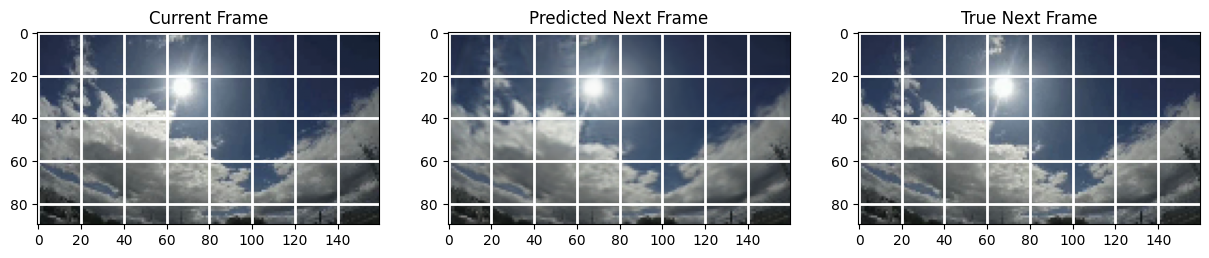

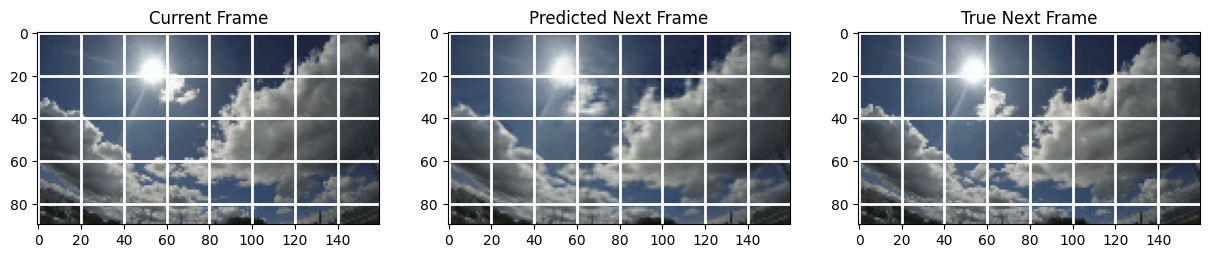

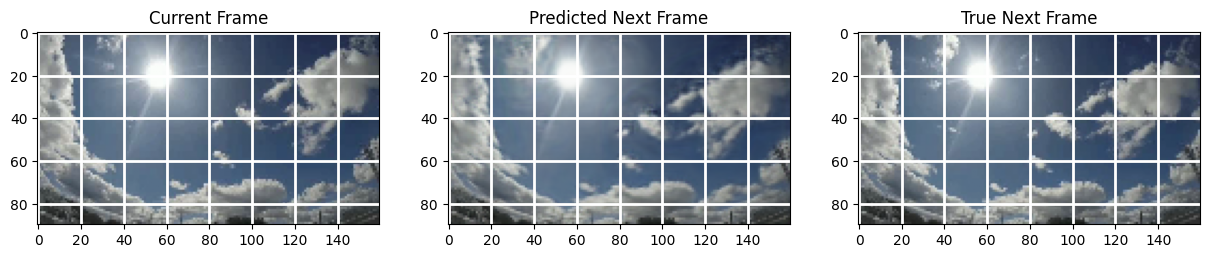

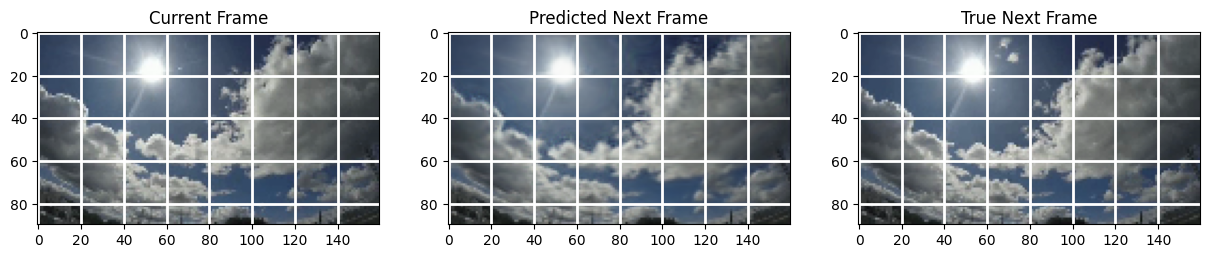

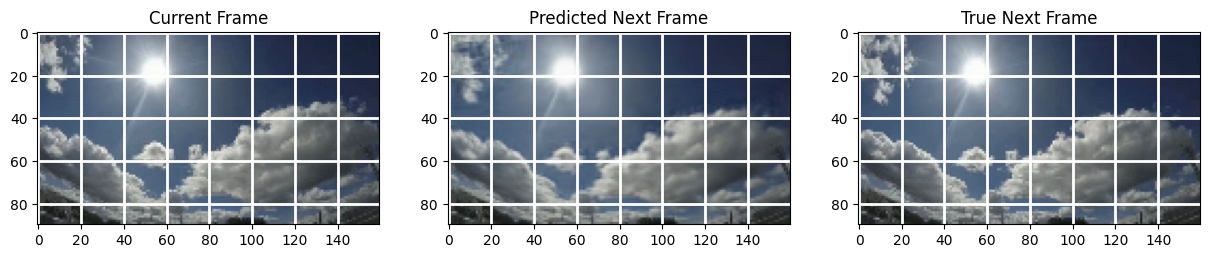

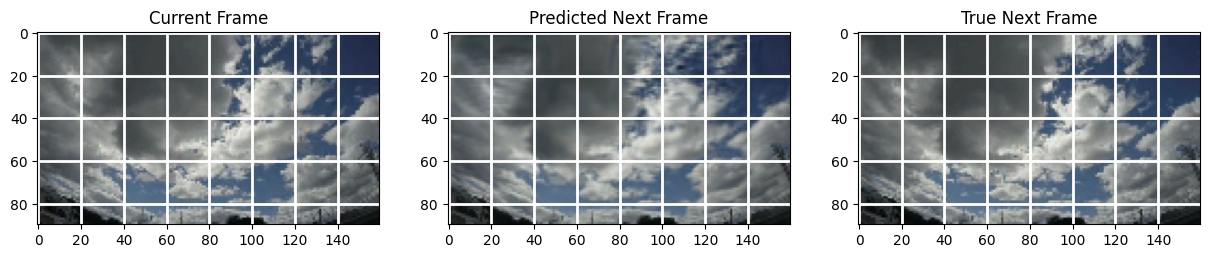

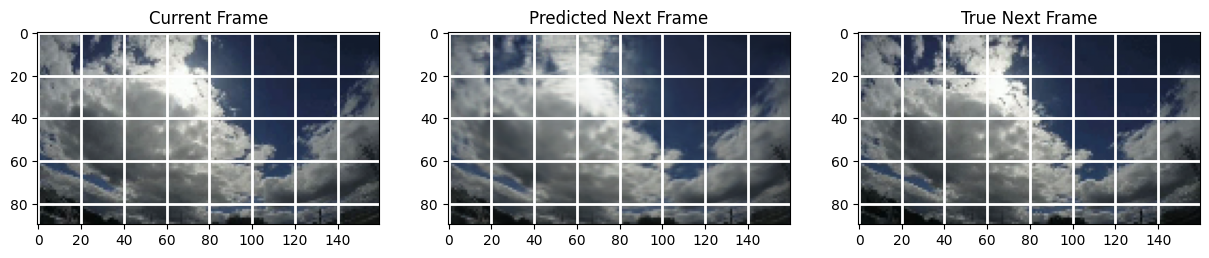

In [6]:
import matplotlib.pyplot as plt

# Evaluate the model
loss = model.evaluate([X_val_frames, X_val_flows], y_val)
print(f"Validation Loss: {loss}")

# Predict future frames
predicted_frames = model.predict([X_val_frames, X_val_flows])

# Visualize a few predictions
n = 10  # Number of predictions to visualize
for i in range(n, n + 7):
    plt.figure(figsize=(15, 5))

    # Current frame
    plt.subplot(1, 3, 1)
    plt.imshow(X_val_frames[i][...,::-1])
    plt.title('Current Frame')
    plt.grid(color='w', linestyle='-', linewidth=2)

    # True next frame
    plt.subplot(1, 3, 3)
    plt.imshow(y_val[i][...,::-1])
    plt.title('True Next Frame')
    plt.grid(color='w', linestyle='-', linewidth=2)

    # Predicted next frame
    plt.subplot(1, 3, 2)
    plt.imshow(predicted_frames[i][...,::-1])
    plt.title('Predicted Next Frame')
    plt.grid(color='w', linestyle='-', linewidth=2)

    plt.show()
